In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import pymc as pm
import pymc_extras.distributions as pmx
import arviz as az
from scipy.stats import genpareto
from datetime import datetime

In [2]:
# Get S&P500 data

data = web.DataReader("^SPX", "stooq", datetime(2021, 1, 1), datetime(2024, 12, 31))
data = data.sort_index()

# Convert S&P data to array

data_array = np.asarray(data)

# Select only closing values

closing_vals = data_array[:, 3]
dates = np.arange(0, np.size(closing_vals))

In [3]:
# Transform closing values to stationary ones using log of sucessive returns

stationary_closing_vals = np.array([])

for i in range(1, np.size(closing_vals)):
    log_diff = np.log(closing_vals[i]) - np.log(closing_vals[i-1])
    stationary_closing_vals = np.append(stationary_closing_vals, log_diff)

date_stationary = np.arange(0, np.size(stationary_closing_vals))

# Select first 1000 entries

stationary_closing_vals = stationary_closing_vals[:1000]

In [4]:
# Choose 95-th percentile as threshhold and compute exceedences

threshhold = np.percentile(stationary_closing_vals, 95)
exceedences = stationary_closing_vals[stationary_closing_vals > threshhold] - threshhold

# Perform a scaling by 100, i.e X -> 100X

exceedences = 100 * exceedences

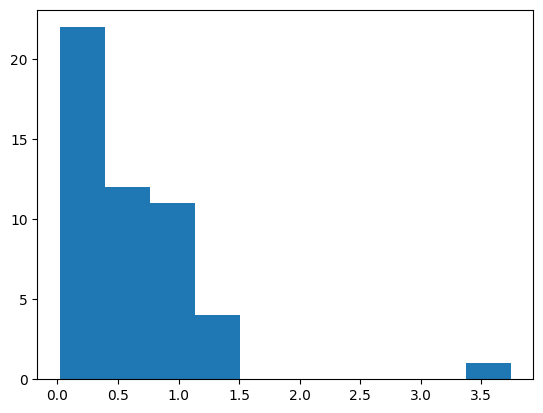

[0.70070756 0.28033093 0.04141159 0.39905317 0.11167094 0.75508372
 0.2204837  0.56210939 0.1965929  0.88686179 0.46774967 0.56319444
 0.79405915 1.29201806 0.70842601 0.34638437 0.18799685 0.3183085
 0.7936041  0.17582083 0.7677434  1.36004826 0.2514169  1.07485036
 0.93149801 0.45621004 0.06690199 0.16697498 0.29760899 0.90495743
 1.36202864 0.9129237  0.96305024 0.69427134 0.78229801 3.74474498
 1.39735331 0.08055645 0.60787867 0.22366171 0.09044968 0.28721129
 0.18011047 0.2177902  0.23902283 0.43978372 0.62760741 0.02021722
 0.03292368 0.84761794]


In [5]:
# Plot in histogram

plt.hist(exceedences)
plt.show()

print(exceedences)

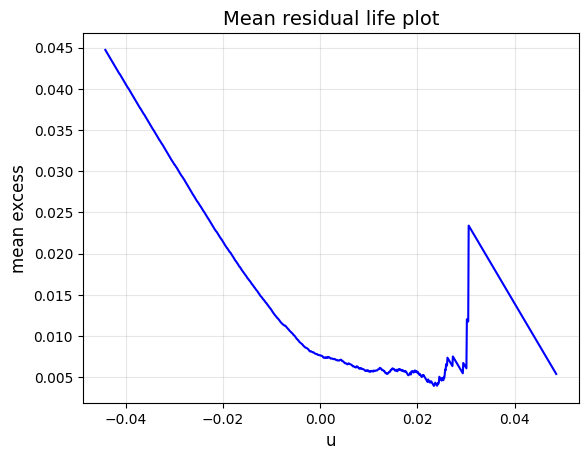

In [6]:
# Create a mean residual life plot to determine threshhold

cut_off = 0.9
threshholds = np.linspace(np.min(stationary_closing_vals), np.max(stationary_closing_vals) * cut_off, 1000)

mean_excess = []

for u in threshholds:
    exceed = stationary_closing_vals[stationary_closing_vals > u]
    if np.size(exceed) > 0:
        mean_excess.append(np.mean(exceed - u))

mean_excess = np.array(mean_excess)

plt.plot(threshholds, mean_excess, color='blue')
plt.grid(True, alpha=0.3)
plt.xlabel('u', fontsize=12)
plt.ylabel('mean excess', fontsize=12)
plt.title('Mean residual life plot', fontsize=14)
plt.show()

In [7]:
# MLE estimates

ξ, μ, σ = genpareto.fit(exceedences)
print(f'MLE estimates are: μ = {np.round(μ, 3)}, σ = {np.round(σ,3)}, ξ = {np.round(ξ,3)}')

MLE estimates are: μ = 0.02, σ = 0.57, ξ = 0.012


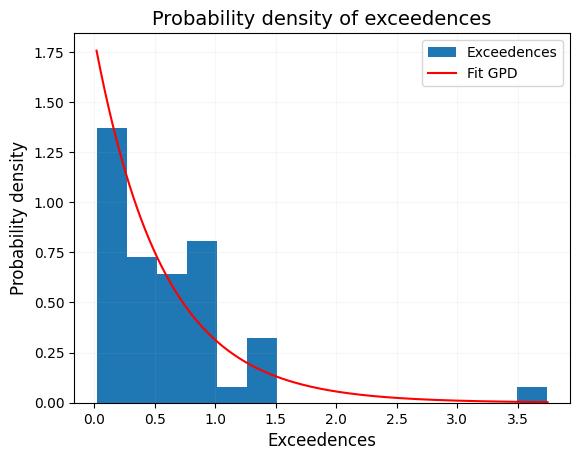

In [8]:
# Plotting of MLE estimates

x = np.linspace(np.min(exceedences), np.max(exceedences), 1000)

pdf = genpareto.pdf(x, ξ, loc=μ, scale=σ)

plt.hist(exceedences, bins=15, density=True, label='Exceedences')
plt.plot(x, pdf, color='red', label='Fit GPD')
plt.grid(True, alpha=0.1)
plt.legend(loc='upper right')
plt.title('Probability density of exceedences', fontsize=14)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel('Exceedences', fontsize=12)
plt.show()

We have that
\begin{equation}
    VaR = u + \frac{\sigma}{\xi} \ln{\left(\frac{p}{1-q} \right)},
\end{equation}

where $p$ is the probability of an observation exceeding the threshhold, $q$ is the confidence level, $\xi$ and $\sigma$ the corresponding shape and scale parameters from the GPD fit. The expression above assumes that $\xi \neq 0$. Furhtermore, is the Expected shortfall given by

\begin{equation}
    ES = VaR + \frac{\sigma + \xi (VaR - u)}{1 - \xi},
\end{equation}

for $\xi < 1$.  

In [9]:
# Determining VaR

def VaR_excess(sigma, xi, p, q):
    return sigma/xi * ((p/(1-q))**xi - 1)

p = np.size(exceedences)/np.size(stationary_closing_vals)
q = 0.99
u_actual = np.percentile(stationary_closing_vals, 95)

VaR = u_actual + VaR_excess(σ, ξ, p, q)

In [10]:
# Determining Expected Shortfall

def ES(var, sigma, xi, u):
    return var + (sigma + xi*(var - u))/(1-xi)

expected_shortfall = ES(VaR, σ, ξ, u_actual)

In [13]:
investment = 10e6
VaR_amount, ES_amount = investment * VaR, investment * expected_shortfall
print(f'VaR amount: {np.round(VaR_amount, 1)}\n')
print(f'ES amount: {np.round(ES_amount, 1)}')

VaR amount: 9420150.5

ES amount: 15294092.5
